In [2]:
# imports here
import os
import sys
from argparse import Namespace
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pytorch_grad_cam import (AblationCAM, EigenCAM, EigenGradCAM, FullGrad,
                              GradCAM, GradCAMPlusPlus, LayerCAM, ScoreCAM,
                              XGradCAM)
from pytorch_grad_cam.utils.image import show_cam_on_image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# own code
sys.path.append('../')
from convnext import LightningConvNeXt
from datasets import DeepRiskDataset2D, MyopsDataset2D
from drn import LightningDRN
from preprocessing import normalize_image, set_image_range
from resnet import LightningResNet
from simplenet import LightningSimpleNet
from train_classifier_2d import load_dataset

Notebook checks other gradcam-like versions/implementations. They did not seem to hold an advantage over regular Class Activation Maps (with Global Average Pooling).

This notebook might need some updates to function with changes in the rest of the code.

# Load models

In [5]:
# load a trained model
drnd24 = LightningDRN(depths=[1, 1, 2, 2, 2, 2, 2, 2], arch="D", num_classes=1, in_chans=1)
drnd24.load_state_dict(torch.load(r"..\..\tb_logs\drnd\version_7\checkpoints\epoch=79-step=12079.ckpt", map_location=torch.device('cpu'))['state_dict'])
drnd24.eval()

drnd24_120epochs = LightningDRN(depths=[1, 1, 2, 2, 2, 2, 2, 2], arch="D", num_classes=1, in_chans=1)
drnd24_120epochs.load_state_dict(torch.load(r"..\..\tb_logs\drnd\version_8\checkpoints\epoch=119-step=18119.ckpt", map_location=torch.device('cpu'))['state_dict'])
drnd24_120epochs.eval()

drnd24_maxpool = LightningDRN(depths=[1, 1, 2, 2, 2, 2, 2, 2], arch="D", num_classes=1, in_chans=1, pooling="max")
drnd24_maxpool.load_state_dict(torch.load(r"..\..\tb_logs\drnd_maxpool\version_1\checkpoints\epoch=119-step=18119.ckpt", map_location=torch.device('cpu'))['state_dict'])
drnd24_maxpool.eval()

drnd18 = LightningDRN(depths=[1, 1, 2, 2, 2, 0, 1, 1], arch="D", num_classes=1, in_chans=1, pooling="max")
drnd18.load_state_dict(torch.load(r"..\..\tb_logs\drnd18\version_0\checkpoints\epoch=299-step=45299.ckpt", map_location=torch.device('cpu'))['state_dict'])
drnd18.eval()

drnd18_e500 = LightningDRN(depths=[1, 1, 2, 2, 2, 0, 1, 1], arch="D", num_classes=1, in_chans=1, pooling="max")
drnd18_e500.load_state_dict(torch.load(r"..\..\tb_logs\drnd18_max\version_0\checkpoints\epoch=499-step=75499.ckpt", map_location=torch.device('cpu'))['state_dict'])
drnd18_e500.eval()


LightningDRN(
  (feature_dropout_layer): Dropout2d(p=0.0, inplace=False)
  (cam_dropout_layer): Dropout(p=0.0, inplace=False)
  (classifier): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
  (final_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (up_bilinear): UpsamplingBilinear2d(scale_factor=8.0, mode=bilinear)
  (up_conv_transpose): ConvTranspose2d(1, 1, kernel_size=(16, 16), stride=(8, 8), padding=(4, 4), bias=False)
  (output2pred): Sigmoid()
  (train_accuracy): Accuracy()
  (validation_accuracy): Accuracy()
  (test_accuracy): Accuracy()
  (train_confusion): ConfusionMatrix()
  (validation_confusion): ConfusionMatrix()
  (test_confusion): ConfusionMatrix()
  (train_auroc): AUROC()
  (validation_auroc): AUROC()
  (test_auroc): AUROC()
  (train_pr_curve): PrecisionRecallCurve()
  (validation_pr_curve): PrecisionRecallCurve()
  (test_pr_curve): PrecisionRecallCurve()
  (train_roc): ROC()
  (validation_roc): ROC()
  (test_roc): ROC()
  (train_auc): AUC()
  (validation_auc): AUC()
  

# Deeprisk data

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hparams = Namespace()
# choose dataset
hparams.dataset = 'deeprisk'
# reproducability
hparams.trainseed = 42
hparams.splitseed = 42
hparams.train_frac = 0.75
# paths
hparams.data_path = r"\\amc.intra\users\R\rcklein\home\deeprisk\weakly_supervised\data"
hparams.img_path = r"all_niftis_n=657"
hparams.weak_labels_path = r"weak_labels_n=657.xlsx"
hparams.myoseg_path = r"nnUnet_results\nnUNet\2d\Task500_MyocardSegmentation\predictions"
hparams.seg_labels_dir = None
# data augmentation
hparams.image_norm = "global_statistic"
hparams.no_roi_crop = False
hparams.include_no_myo = False
hparams.roi_crop = "fixed" # "fitted", or "fixed"
hparams.center_crop = 224
hparams.input_size = 224
hparams.rotate = 0
hparams.translate = (0, 0)
hparams.scale = (1, 1)
hparams.shear = (0, 0, 0, 0)
hparams.brightness = 0
hparams.contrast = 0
hparams.hflip = False
hparams.vflip = False
hparams.randomaffine_prob=0
hparams.randomcrop = False
hparams.randomerasing_probs = []
print(f'{hparams=}')

pl.seed_everything(hparams.trainseed, workers=True)
# prepare dataloaders
dataset_train, dataset_val, dataset_test = load_dataset(hparams)
print(f"Train data: {len(dataset_train)}, validation data {len(dataset_val)}")

train_loader = DataLoader(dataset_train,
                            batch_size=1,
                            shuffle=False,
                            drop_last=False,
                            num_workers=1)
val_loader = DataLoader(dataset_val,
                        batch_size=1,
                        shuffle=False,
                        drop_last=False,
                        num_workers=1)


Global seed set to 42


hparams=Namespace(dataset='deeprisk', trainseed=42, splitseed=42, train_frac=0.75, data_path='\\\\amc.intra\\users\\R\\rcklein\\home\\deeprisk\\weakly_supervised\\data', img_path='all_niftis_n=657', weak_labels_path='weak_labels_n=657.xlsx', myoseg_path='nnUnet_results\\nnUNet\\2d\\Task500_MyocardSegmentation\\predictions', seg_labels_dir=None, image_norm='global_statistic', no_roi_crop=False, include_no_myo=False, roi_crop='fixed', center_crop=224, input_size=224, rotate=0, translate=(0, 0), scale=(1, 1), shear=(0, 0, 0, 0), brightness=0, contrast=0, hflip=False, vflip=False, randomaffine_prob=0, randomcrop=False, randomerasing_probs=[])
train transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    Normalize(mean=[0.57], std=[0.06])
    RandomApply(
    p=0
    RandomAffine(degrees=[0.0, 0.0], scale=(1, 1), shear=[0.0, 0.0, 0.0, 0.0], interpolation=bilinear)
)

In [7]:
def plot_cam_gen(dataloader, net, cam_methods=[], wrong_only=False):
    n = 0
    for batch in dataloader:
        inputs = batch[-2]
        labels = batch[-1]
        bath_paths = batch[0]
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        preds = (torch.sigmoid(outputs) > 0.5)[:, 0].int()
        
        cam_batch = {}
        cam_batch['normal_cam'] = selected_model.make_cam(inputs, select_values="pos_only", upsampling="conv_transpose").detach()[:,0]
        for cam_method in cam_methods:
            cam_batch[cam_method[0]] = cam_method[1](input_tensor=inputs, targets=None)
        
        for i in range(inputs.shape[0]):
            print(f"label:{labels[i].item()} predicted: {int(preds[i].item())} score: {torch.sigmoid(outputs[i]).detach().numpy()[0]:.3f}")
            fig, axs = plt.subplots(1, 2+len(cam_methods), figsize=(15, 5))
            axs[0].imshow(inputs[i][0], cmap="gray")
            axs[0].set_title("Reference image")
            axs[1].imshow(inputs[i][0], cmap='gray')
            axs[1].imshow(cam_batch['normal_cam'][i], cmap="coolwarm", alpha=0.5, vmin=0.0, vmax=1)
            axs[1].set_title("Normal CAM")
            for j in range(2, len(cam_methods)+2):
                axs[j].imshow(inputs[i][0], cmap='gray')
                axs[j].imshow(cam_batch[cam_methods[j-2][0]][i], cmap="coolwarm", alpha=0.5, vmin=0.0, vmax=1)
                axs[j].set_title(f"{cam_methods[j-2][0]}")
            fig.colorbar(cm.ScalarMappable(cmap="coolwarm"), ax=axs.ravel().tolist())
            plt.show()
            yield
        

In [59]:
selected_model = drnd18
target_layers = [selected_model.layer7]

gradcam = ("gradcam", GradCAM(model=selected_model, target_layers=target_layers))
gradcamplusplus = ("gradcam++", GradCAMPlusPlus(model=selected_model, target_layers=target_layers))
xgradcam = ("xgradcam", XGradCAM(model=selected_model, target_layers=target_layers))
eigencam = ("eigencam", EigenCAM(model=selected_model, target_layers=target_layers))
eigengradcam = ("eigengradcam", EigenGradCAM(model=selected_model, target_layers=target_layers))
layercam = ("layercam", LayerCAM(model=selected_model, target_layers=target_layers))
fullgrad = ("fullgrad", FullGrad(model=selected_model, target_layers=target_layers))

scorecam_  = ScoreCAM(model=selected_model, target_layers=[])
scorecam_.batch_size = 8
scorecam = ("scorecam", scorecam_)
ablationcam_ = AblationCAM(model=selected_model, target_layers=target_layers)
ablationcam_.batch_size = 8
ablationcam = ("ablationcam", ablationcam_)

cam_methods = [gradcam, gradcamplusplus, xgradcam, eigencam, eigengradcam, layercam]
train_cam_examples = plot_cam_gen(train_loader, selected_model, cam_methods=cam_methods, wrong_only=False)
val_cam_examples = plot_cam_gen(val_loader, selected_model, cam_methods=cam_methods, wrong_only=False)

label:1 predicted: 1 score: 0.980


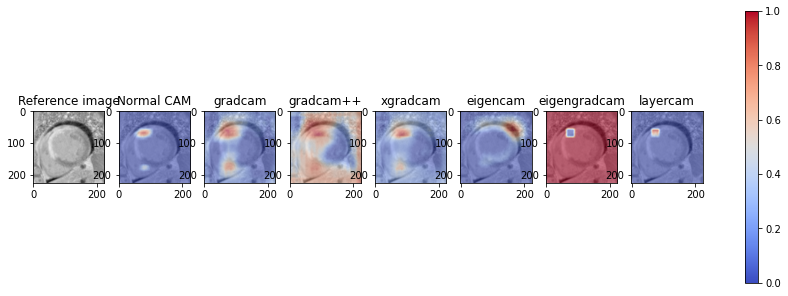

In [75]:
next(train_cam_examples)

label:0 predicted: 0 score: 0.204


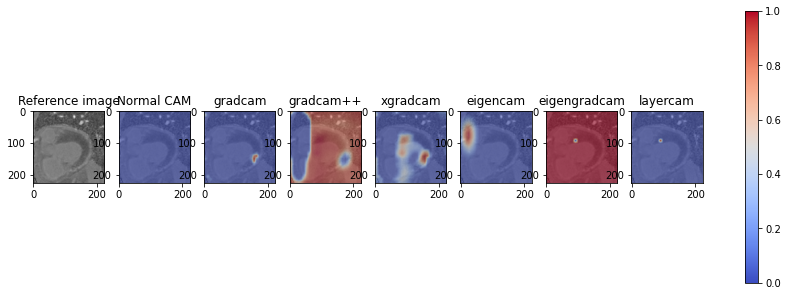

In [42]:
next(val_cam_examples)